# Homework 7: Problems

### ASTROINFORMATICS
https://github.com/astromundus/astroinfo2018/blob/master/homework/HW7.ipynb

## Problem: use KDE to make Hess-like diagrams

Use Kernel Density Estimation (KDE) with a top-hat, Gaussian, and exponential 
kernel to analyze 4-D data for variable stars from the SDSS and LINEAR surveys:
-- SDSS u-g and g-i colors,
-- LINEAR variability period (logP) and variability amplitude (A), that
you already encountered in Homework 6. Please produce the g-i vs. u-g, and 
A vs. logP, diagrams for each of the three kernels above (that is, make the 
analogs of Figure 6.3 from the textbook). Experiment with different kernel 
bandwidths, plotting one that visually seems "best" (i.e., a good balance of 
bias vs. variance) for each kernel.

Please change the original figure size (i.e. the size of Figure 6.3) so that 
individual panels in your solution have aspect ratios closer to what is common 
for color-magnitude diagrams (i.e., x:y $\approx$ 4:6 or so).






<br>
# Homework 7: Solutions

### Some useful definitions and functions

In [5]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import norm
from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_LINEAR_geneva
from astroML.datasets import fetch_great_wall
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse
from astroML.plotting import setup_text_plots

setup_text_plots(fontsize=16, usetex=True)

from sklearn.neighbors import KernelDensity as KDE

## Problem 1
First obtain LINEAR data for 6,146 stars using astroML built-in function: 

In [6]:
data = fetch_LINEAR_geneva()
# N.B. this is a 7-dimensional dataset
A = data['amp']
ug = data['ug']
gi = data['gi']
logP = data['logP']
# will need for GMM clustering analysis
# X = np.vstack([data['gi'], data['ug'], data['amp'], data['logP']]).T

and plot a few diagrams just to make sure that data are fine...

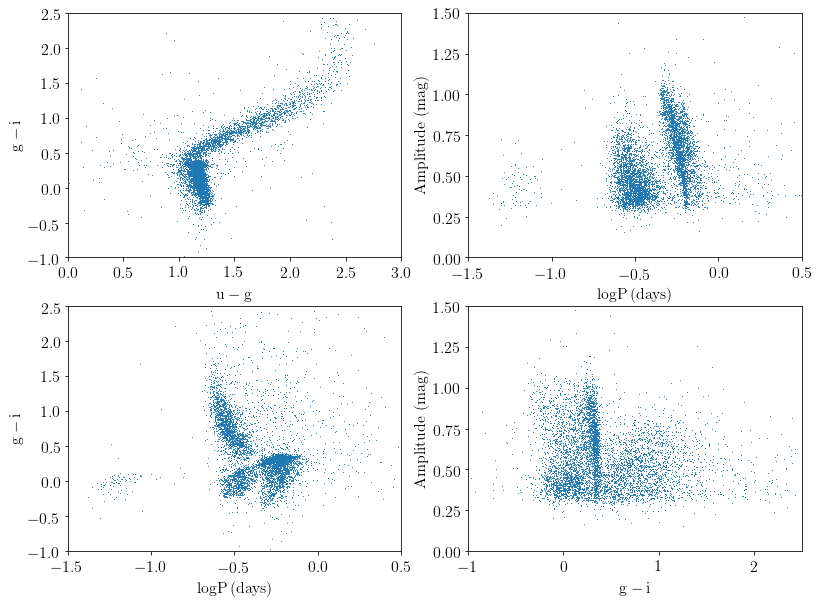

In [7]:
# set up the plot
fig = plt.figure(figsize=(12, 9), facecolor='w')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2, bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = fig.add_subplot(221)
ax1.scatter(ug, gi, s=0.9, lw=0)
ax1.set_xlim(0.0, 3.0)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='k')
ax1.set_ylabel(r'${\rm g-i}$', color='k')

# plot the A vs. logP plot
ax2 = fig.add_subplot(222)
ax2.scatter(logP, A, s=0.9, lw=0)
ax2.set_xlim(-1.5, 0.5)
ax2.set_ylim(0.0, 1.5)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

# g-i vs. logP
ax3 = fig.add_subplot(223)
ax3.scatter(logP, gi, s=0.9, lw=0)
ax3.set_xlim(-1.5, 0.5)
ax3.set_ylim(-1.0, 2.5)
ax3.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax3.set_ylabel(r'${\rm g-i}$', color='k')

# A vs. g-i 
ax4 = fig.add_subplot(224)
ax4.scatter(gi, A, s=0.9, lw=0)
ax4.set_xlim(-1.0, 2.5)
ax4.set_ylim(0.0, 1.5)
ax4.set_xlabel(r'${\rm g-i}$', color='k')
ax4.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

plt.show()

And then do the required KDE analysis...

In [43]:
def kde_dist(h1,h2,h3,Nx,Ny,xmin,xmax,ymin,ymax,X,label):
    #------------------------------------------------------------
    # Evaluate for several models
    Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                    np.linspace(ymin, ymax, Ny)))).T
    kde1 = KDE(h1, kernel='gaussian')
    log_dens1 = kde1.fit(X).score_samples(Xgrid)
    dens1 = X.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

    kde2 = KDE(h2, kernel='tophat')
    log_dens2 = kde2.fit(X).score_samples(Xgrid)
    dens2 = X.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

    kde3 = KDE(h3, kernel='exponential')
    log_dens3 = kde3.fit(X).score_samples(Xgrid)
    dens3 = X.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

    # Plot the results
    fig = plt.figure(figsize=(9,12))
    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                        hspace=0.01, wspace=0.01)

    # First plot: scatter the points
    ax1 = plt.subplot(221, aspect='equal')
    ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
    ax1.text(0.95, 0.9, "input", ha='right', va='top',
             transform=ax1.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Second plot: gaussian kernel
    ax2 = plt.subplot(222, aspect='equal')
    ax2.imshow(dens1.T, origin='lower', norm=LogNorm(),
               extent=(ymin, ymax, xmin, xmax))#, cmap=plt.cm.binary)
    ax2.text(0.95, 0.9, "Gaussian $(h=%.2f)$"%h1, ha='right', va='top',
             transform=ax2.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Third plot: top-hat kernel
    ax3 = plt.subplot(223, aspect='equal')
    ax3.imshow(dens2.T, origin='lower', norm=LogNorm(),
               extent=(ymin, ymax, xmin, xmax))#, cmap=plt.cm.binary)
    ax3.text(0.95, 0.9, "top-hat $(h=%.2f)$"%h2, ha='right', va='top',
             transform=ax3.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))
    ax3.images[0].set_clim(0.01, 0.8)

    # Fourth plot: exponential kernel
    ax4 = plt.subplot(224, aspect='equal')
    ax4.imshow(dens3.T, origin='lower', norm=LogNorm(),
               extent=(ymin, ymax, xmin, xmax))#, cmap=plt.cm.binary)
    ax4.text(0.95, 0.9, "exponential $(h=%.2f)$"%h3, ha='right', va='top',
             transform=ax4.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(ymin, ymax - 0.01)
        ax.set_ylim(xmin, xmax)

    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax3, ax4]:
        ax.set_xlabel(r'$%s$'%label[1])

    for ax in [ax2, ax4]:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax1, ax3]:
        ax.set_ylabel(r'$%s$'%label[0])

    plt.show()

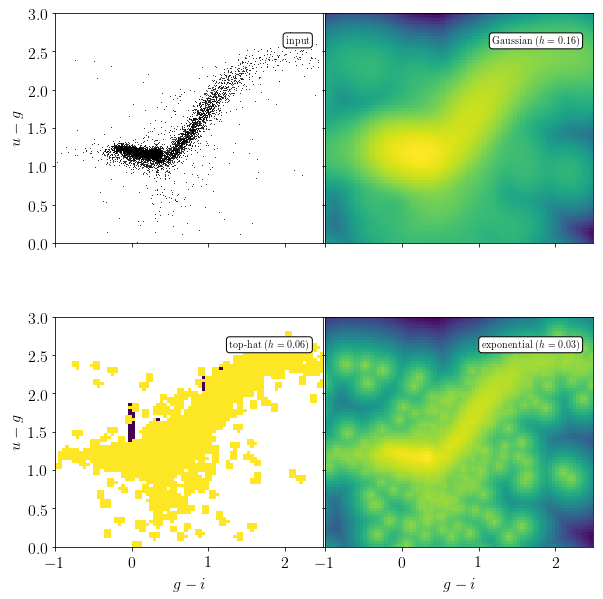

THIS WILL NOT HAVE NO BALANCE OF GOOD BIAS AND VARIANCE
WITH HIGHER values OF THE BADND


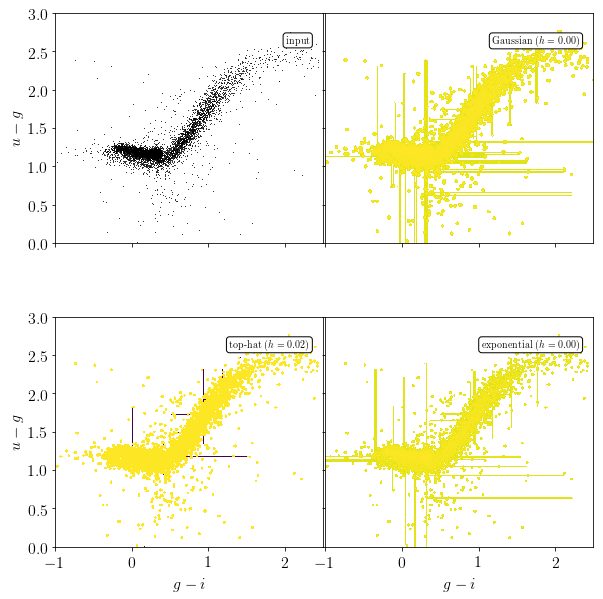

In [46]:
X = np.vstack([data['ug'], data['gi']]).T
xmin, xmax = (0,3)
ymin, ymax = (-1,2.5)

Nx = 77
Ny = 77
h1,h2,h3 = (0.16,0.06,0.03)
kde_dist(h1,h2,h3,Nx,Ny,xmin,xmax,ymin,ymax,X,['u-g','g-i'])

print("THIS WILL NOT HAVE NO BALANCE OF GOOD BIAS AND VARIANCE")
print("WITH HIGHER values OF THE BANDWIDTH")
Nx=250
Ny=250
h1,h2,h3 = 0.003,0.02,0.0005
kde_dist(h1,h2,h3,Nx,Ny,xmin,xmax,ymin,ymax,X,['u-g','g-i'])

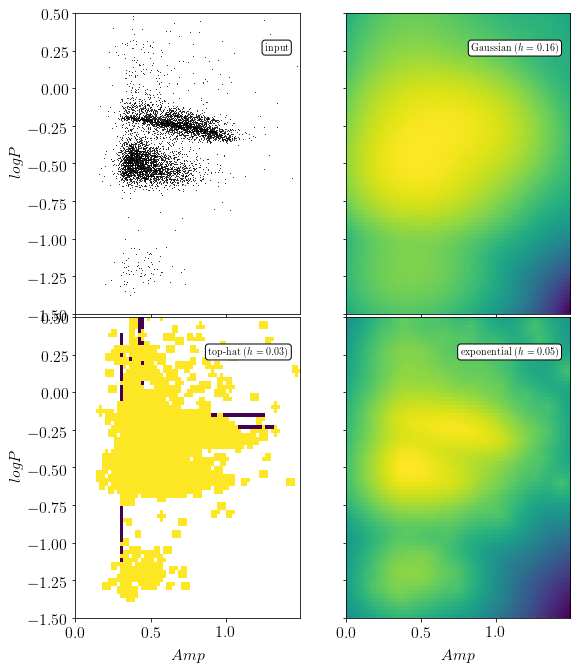

THIS WILL NOT HAVE NO BALANCE OF GOOD BIAS AND VARIANCE
WITH HIGHER values OF THE BANDWIDTH


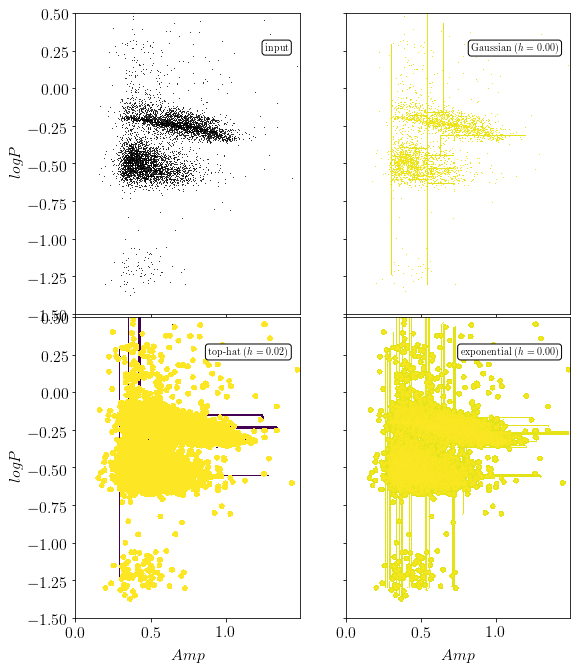

In [49]:
X = np.vstack([data['logP'], data['amp']]).T
xmin, xmax = (-1.5,0.5)
ymin, ymax = (0,1.5)

h1,h2,h3=(0.16,0.03,0.05)
Ny = 75
Nx = 75
kde_dist(h1,h2,h3,Nx,Ny,xmin,xmax,ymin,ymax,X,['logP','Amp'])

print("THIS WILL NOT HAVE NO BALANCE OF GOOD BIAS AND VARIANCE")
print("WITH HIGHER values OF THE BANDWIDTH")

h1,h2,h3=(0.0003,0.02,0.0005)
Ny = 300
Nx = 300
kde_dist(h1,h2,h3,Nx,Ny,xmin,xmax,ymin,ymax,X,['logP','Amp'])